## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937540e+11,4.866080e+10,4.082033e+10,3.646072e+10,1.420310e+11,1.586160e+11,6.168697e+10,3.337392e+10,1.645040e+11,8.897731e+10,...,25598248500,1.527560e+11,1.785760e+11,27214839130,3.663840e+10,6.715592e+10,4.133704e+10,9.453677e+10,2.066260e+11,3.272110e+11
2010-01-05,1.940890e+11,4.855377e+10,4.215727e+10,3.689663e+10,1.413990e+11,1.597390e+11,6.153308e+10,3.486077e+10,1.653560e+11,9.055040e+10,...,25700093100,1.505780e+11,1.786350e+11,26570118990,3.658030e+10,6.615275e+10,4.086336e+10,9.470720e+10,2.045680e+11,3.284880e+11
2010-01-06,1.910010e+11,4.933862e+10,4.343609e+10,3.700873e+10,1.404780e+11,1.597590e+11,6.120609e+10,3.547838e+10,1.645040e+11,8.958393e+10,...,25543409100,1.500930e+11,1.777880e+11,26193121620,3.694052e+10,6.580586e+10,4.031464e+10,9.067348e+10,2.041110e+11,3.313270e+11
2010-01-07,1.906480e+11,4.992131e+10,4.519446e+10,3.715818e+10,1.411110e+11,1.591570e+11,6.122532e+10,3.550126e+10,1.730220e+11,9.133695e+10,...,26172872700,1.495290e+11,1.768230e+11,26570118990,3.835818e+10,6.608712e+10,4.068983e+10,9.013376e+10,2.042250e+11,3.302860e+11
2010-01-08,1.919160e+11,4.988564e+10,4.475850e+10,3.757541e+10,1.418590e+11,1.594380e+11,6.132150e+10,3.562706e+10,1.767480e+11,8.960963e+10,...,26121202640,1.507390e+11,1.765900e+11,26531872880,3.799796e+10,6.621838e+10,4.080239e+10,9.019057e+10,2.031960e+11,3.289620e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

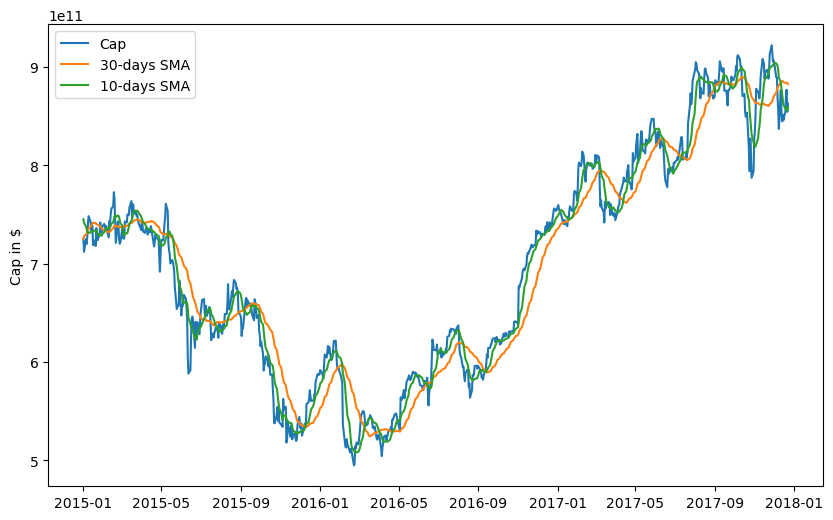

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$

Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


In [124]:
# ---CELL 7: Data Prep ---

#Auditability (grounding toggle)
np.random.seed(42)
tf.random.set_seed(42)

# Global Scaling
avg_market_cap = df_cap.sum(axis=1).mean()
df_cap_avg = df_cap / avg_market_cap

# Re-basing SMAs (Setting each starting signal to 1.0)
short_avg = short_rolling / avg_market_cap
long_avg = long_rolling / avg_market_cap

short_rebased = short_avg / short_avg.apply(lambda x: x.loc[x.first_valid_index()])
long_rebased = long_avg / long_avg.apply(lambda x: x.loc[x.first_valid_index()])

# Signals (Arithmetic Returns)
signal_1 = short_rebased.pct_change(periods=1).shift(-1)
signal_2 = long_rebased.pct_change(periods=1).shift(-1)

# Alignment
market_cap_subset = df_cap_avg[:-1]
common_idx = signal_1.dropna().index.intersection(signal_2.dropna().index).intersection(market_cap_subset.index)

x_data = market_cap_subset.loc[common_idx]
z1_data = signal_1.loc[common_idx]
z2_data = signal_2.loc[common_idx]

# Tensors
x_t = tf.constant(x_data.values, dtype=tf.float32)
z1_t = tf.constant(z1_data.values, dtype=tf.float32)
z2_t = tf.constant(z2_data.values, dtype=tf.float32)

num_steps, num_stocks = x_t.shape
print(f"Data Prepared. Steps: {num_steps}, Stocks: {num_stocks}")

Data Prepared. Steps: 2050, Stocks: 30


In [ ]:
# --- CELL 8: Model Definition ---

# Variable Initializations
kappa = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="kappa")
sigma = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="sigma")
# Softmax Logits:
w_logits = tf.Variable(tf.random.normal([num_stocks, 2], mean=0.0, stddev=0.1), name="w_logits")

def get_loss():
    # Softmax Normalization
    weights = tf.nn.softmax(w_logits, axis=1)
    W1 = weights[:, 0]
    W2 = weights[:, 1]
    
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    actual_log_r = log_x_next - log_x
    
    z1_log = tf.math.log(1.0 + z1_t)
    z2_log = tf.math.log(1.0 + z2_t)
    
    # Log Mean Projection
    log_x0 = tf.slice(log_x, [0, 0], [1, -1])
    wtd_returns = W1 * z1_log + W2 * z2_log
    theta_log = log_x0 + tf.math.cumsum(wtd_returns, axis=0)
    
    # Expected Return
    reversion = kappa * (theta_log - log_x)
    exp_ret = wtd_returns + reversion
    
    # Residuals
    v_res = (actual_log_r - exp_ret)[:-1, :]
    
    # Gaussian NLL
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma)))
    
    neg_log_prob = 0.5 * (sq_dist + log_det)
    
    return neg_log_prob

In [126]:
# --- CELL 9: Optimization ---
optimizer = tf.optimizers.Adam(learning_rate=0.001)
variables = [kappa, sigma, w_logits]

print("Calibrating Model...")
for i in range(2001):
    with tf.GradientTape() as tape:
        loss_val = get_loss()
    
    # Gradients
    grads = tape.gradient(loss_val, variables)
    optimizer.apply_gradients(zip(grads, variables))
    
    # Stability constraints
    kappa.assign(tf.maximum(0.00001, kappa))
    sigma.assign(tf.maximum(0.00001, sigma))
    
    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val.numpy():.4f}")

print("Done")

weights = tf.nn.softmax(w_logits, axis=1)
W1, W2 = weights[:, 0], weights[:, 1]

z1_log = tf.math.log(1.0 + z1_t)
z2_log = tf.math.log(1.0 + z2_t)

ma10_cont = W1 * z1_log
ma30_cont = W2 * z2_log

print(f"\nSignal Contribution Analysis:")
print(f"MA10 contribution std: {tf.math.reduce_std(ma10_cont).numpy():.6f}")
print(f"MA30 contribution std: {tf.math.reduce_std(ma30_cont).numpy():.6f}")

Calibrating Model...
Iteration    0 | Loss: -40714.8164
Iteration  500 | Loss: -182241.8281
Iteration 1000 | Loss: -240031.5469
Iteration 1500 | Loss: -240059.9531
Iteration 2000 | Loss: -240073.6250
Done

Signal Contribution Analysis:
MA10 contribution std: 0.003483
MA30 contribution std: 0.000436


In [133]:
# --- CELL 10: Results ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

final_weights = tf.nn.softmax(w_logits, axis=1).numpy()
W1_final = final_weights[:, 0]
W2_final = final_weights[:, 1]

results = {
    'Ticker': df_cap.columns,
    'Kappa (Log)': kappa.numpy(),
    'Sigma (Log)': sigma.numpy(),
    'W1 (MA10)': W1_final,
    'W2 (MA30)': W2_final,
    'Sum_Weights': W1_final + W2_final
}
df_results = pd.DataFrame(results)

print("---------- Part 1: Final Calibration Results (Log-Normal OU) ----------")
df_results  # Display without print



---------- Part 1: Final Calibration Results (Log-Normal OU) ----------


,Ticker,Kappa (Log),Sigma (Log),W1 (MA10),W2 (MA30),Sum_Weights
0,AAPL,0.110910,0.014684,0.707648,0.292352,1.000000
1,AXP,0.094199,0.013777,0.607300,0.392700,1.000000
2,BA,0.051350,0.014045,0.954613,0.045387,1.000000
3,CAT,0.047598,0.015708,0.702413,0.297587,1.000000
4,CSCO,0.144472,0.014758,0.963148,0.036852,1.000000
5,CVX,0.176251,0.012236,0.806296,0.193704,1.000000
6,DIS,0.149036,0.012427,0.881602,0.118398,1.000000
7,DWDP,0.136110,0.021146,0.770522,0.229478,1.000000
8,GE,0.195355,0.012733,0.951262,0.048738,1.000000
9,GS,0.153883,0.015358,0.822475,0.177525,1.000000


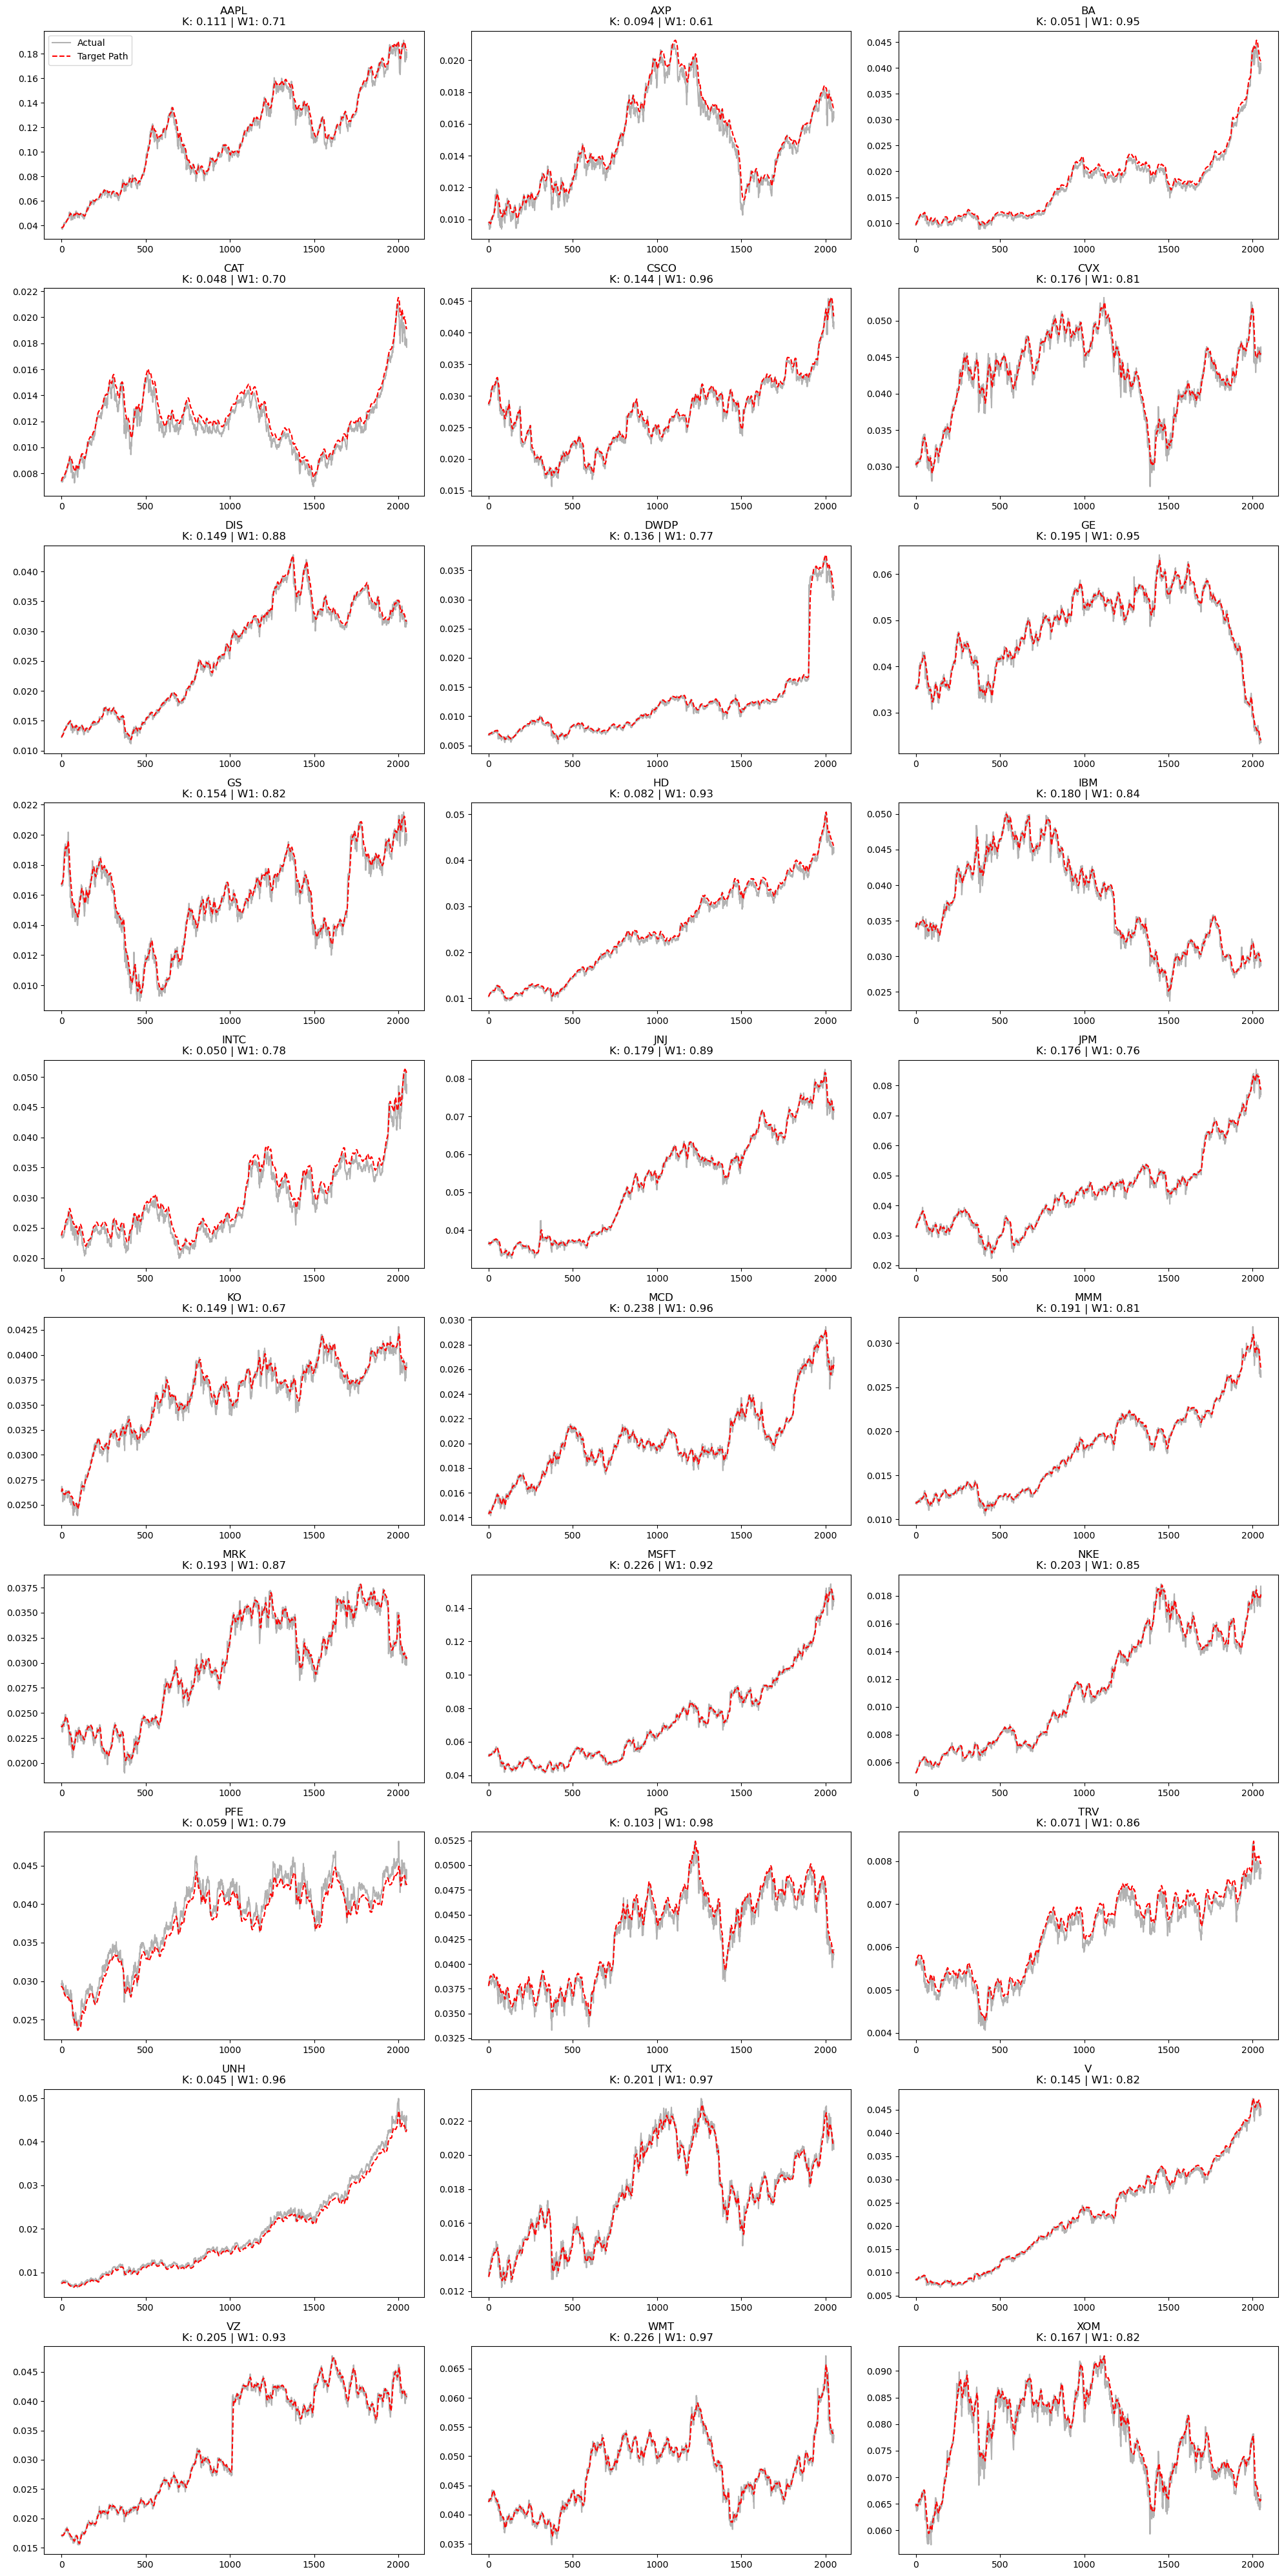

In [134]:
# --- CELL 11: Charts ---
n_cols = 3
n_rows = (num_stocks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Softmax weights for plotting
weights_plot = tf.nn.softmax(w_logits, axis=1).numpy()
W1_plot = weights_plot[:, 0]
W2_plot = weights_plot[:, 1]

for i in range(num_stocks):
    # Signals
    log_x0 = tf.math.log(x_t[0, i])
    z1_log = tf.math.log(1.0 + z1_t[:, i])
    z2_log = tf.math.log(1.0 + z2_t[:, i])
    
    # Reconstruct the Target Path
    path_arith = tf.exp(log_x0 + tf.math.cumsum(W1_plot[i] * z1_log + W2_plot[i] * z2_log)).numpy()
    
    # Plotting
    axes[i].plot(x_t[:, i].numpy(), color='black', alpha=0.3, label='Actual')
    axes[i].plot(path_arith, color='red', linestyle='--', label='Target Path')
    
    # Metadata
    axes[i].set_title(f"{df_cap.columns[i]}\nK: {kappa[i].numpy():.3f} | W1: {W1_plot[i]:.2f}")
    if i == 0: 
        axes[i].legend()

plt.tight_layout()
plt.show()

## Part 2: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


Part 2 will add a momentum indicator - Volatility-Adjusted Momentum (VAM). 

Persistent momentum and mean-reversion are two sides of the same coin. Secondary indicators, MAs, RSI, Bollinger, MACD, etc. are useful under certain conditions and must often be combined with other signals and chart patterns to be useful. Non-stationarity makes usefulness of any static combination of these limited to short, revolving time frames. And since we are using moving averages which are lagging indicators, VAM adds a forward-looking variable. 

VAM attempts to score the momentum (return) of a stock in terms of its volatility which can ber measured as sigma, average true range, or other indicator. This model will simply use sigma. A high ratio or score indicates breakout, near 0 indicates sideways movement, and negative signals mean-reversion. To hopefully avoid collinearity, the VAM in this model will have a dynamic signal that adjusts between a 10-day and a 60-day measurement of return and uses a ratio to allow the signal to adjust between those time periods as the signal becomes useful in the model.

In [ ]:
# ---CELL 12: Data Prep ---

# Velocity-Adjusted Momentum (VAM):

# Log Returns
log_S = np.log(df_cap_avg)
log_r = log_S.diff(1)

# Volatility components for dynamic lookback
vol_short = log_r.rolling(window=10).std()
vol_long = log_r.rolling(window=60).std()
vol_ratio = (vol_short / vol_long).clip(0, 0.9).fillna(1.0)

# Dynamic Window 
lb_window = (10 + (60 - 10) * (1.0 - vol_ratio)).astype(int)

# Momentum Signal: (Price[t] - Price[t-lb]) / Price[t-lb]
vam_signal = pd.DataFrame(index=df_cap_avg.index, columns=df_cap_avg.columns)

for col in df_cap_avg.columns:
    prices = df_cap_avg[col].values
    lbs = lb_window[col].values
    mom_array = np.zeros(len(prices))
    
    # We must loop because the lookback 'lb' is different for every timestamp 'i'
    for i in range(60, len(prices)):
        lb = lbs[i]
        past_price = prices[i - lb]
        # Using percentage change as the momentum signal
        mom_array[i] = np.log(prices[i] / past_price) / lb
        
    vam_signal[col] = mom_array
spx_signal_3 = vam_signal.shift(-1)

# Alignment
z3_data = spx_signal_3.loc[common_idx]

# Tensors
""" `
Defined in Part 1
x_t = tf.constant(x_data.values, dtype=tf.float32)
z1_t = tf.constant(z1_data.values, dtype=tf.float32)
z2_t = tf.constant(z2_data.values, dtype=tf.float32)
"""
z3_t = tf.constant(z3_data.values, dtype=tf.float32)

print(f"VAM Signal Ready. Shape: {z3_t.shape}")

VAM Signal Ready. Shape: (2050, 30)


In [ ]:
# --- CELL 13: Model Definition ---

# Variable Initializations
kappa_2 = tf.Variable(tf.random.uniform([num_stocks_2], minval=0.0, maxval=1.0), name="kappa")
sigma_2 = tf.Variable(tf.random.uniform([num_stocks_2], minval=0.0, maxval=1.0), name="sigma")
# Softmax Logits - 3 Signals:
w_logits_2 = tf.Variable(tf.random.normal([num_stocks_2, 3], mean=0.0, stddev=0.1), name="w_logits_2")

def get_loss_2():
    # Softmax Normalization (Regularization)
    weights = tf.nn.softmax(w_logits_2, axis=1)
    W1_2 = weights[:, 0] # MA10
    W2_2 = weights[:, 1] # MA30
    W3_2 = weights[:, 2] # VAM Weight

    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    actual_log_r = log_x_next - log_x
    
    z1_log = tf.math.log(1.0 + z1_t)
    z2_log = tf.math.log(1.0 + z2_t)
    z3_log = z3_t  # VAM as drift term

    # Log Mean Projection
    log_x0 = tf.slice(log_x, [0, 0], [1, -1])
    wtd_returns = W1_2 * z1_log + W2_2 * z2_log + W3_2 * z3_log
    theta_log = log_x0 + tf.math.cumsum(wtd_returns, axis=0)
    
    # Expected Return
    reversion = kappa_2 * (theta_log - log_x)
    exp_ret = wtd_returns + reversion
    
    # Residuals
    v_res = (actual_log_r - exp_ret)[:-1, :]
    
    # Gaussian NLL
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma_2))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma_2)))
    
    neg_log_prob = 0.5 * (sq_dist + log_det)

    return neg_log_prob

In [99]:
# --- CELL 14: Optimization ---
optimizer_2 = tf.optimizers.Adam(learning_rate=0.001)
variables_2 = [kappa_2, sigma_2, w_logits_2]

print("Calibrating Part 2 Model...")
for i in range(2501):
    with tf.GradientTape() as tape:
        loss_val = get_loss_2()
    
    # Gradients
    grads = tape.gradient(loss_val, variables_2)
    optimizer_2.apply_gradients(zip(grads, variables_2))
    
    # Stability constraints
    kappa_2.assign(tf.maximum(0.00001, kappa_2))
    sigma_2.assign(tf.maximum(0.00001, sigma_2))
    
    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val.numpy():.4f}")

print("Done")

weights_2 = tf.nn.softmax(w_logits_2, axis=1)
W1_2, W2_2, W3_2 = weights_2[:, 0], weights_2[:, 1], weights_2[:, 2]

z1_log = tf.math.log(1.0 + z1_t)
z2_log = tf.math.log(1.0 + z2_t)
z3_log = tf.math.log(1.0 + z3_t)

ma10_cont2 = W1_2 * z1_log
ma30_cont2 = W2_2 * z2_log
vam_cont2 = W3_2 * z3_log

print(f"\nSignal Contribution Analysis:")
print(f"MA10 contribution std: {tf.math.reduce_std(ma10_cont2).numpy():.6f}")
print(f"MA30 contribution std: {tf.math.reduce_std(ma30_cont2).numpy():.6f}")
print(f"VAM contribution std: {tf.math.reduce_std(vam_cont2).numpy():.6f}")

Calibrating Part 2 Model...
Iteration    0 | Loss: -58265.4531
Iteration  500 | Loss: -188050.6406
Iteration 1000 | Loss: -240051.3906
Iteration 1500 | Loss: -240420.0938
Iteration 2000 | Loss: -240542.1719
Iteration 2500 | Loss: -240619.5469
Done

Signal Contribution Analysis:
MA10 contribution std: 0.003340
MA30 contribution std: 0.000271
VAM contribution std: 0.000460


In [136]:
# --- CELL 15: Results ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

final_weights_2 = tf.nn.softmax(w_logits_2, axis=1).numpy()
W1_final_2 = final_weights_2[:, 0]
W2_final_2 = final_weights_2[:, 1]
W3_final_2 = final_weights_2[:, 2]

results_2 = {
    'Ticker': df_cap.columns,
    'Kappa (Log)': kappa_2.numpy(),
    'Sigma (Log)': sigma_2.numpy(),
    'W1 (MA10)': W1_final_2,
    'W2 (MA30)': W2_final_2,
    'W3 (VAMS)': W3_final_2,
    'Sum_Weights': W1_final_2 + W2_final_2 + W3_final_2
}
df_results_2 = pd.DataFrame(results_2)

print("-------------- Part 2: Final Calibration Results (VAMS Integrated) --------------")
df_results_2 

-------------- Part 2: Final Calibration Results (VAMS Integrated) --------------


,Ticker,Kappa (Log),Sigma (Log),W1 (MA10),W2 (MA30),W3 (VAMS),Sum_Weights
0,AAPL,0.181100,0.014385,0.839897,0.100256,0.059847,1.000000
1,AXP,0.124803,0.013626,0.711546,0.201621,0.086833,1.000000
2,BA,0.125377,0.013799,0.592067,0.248989,0.158944,1.000000
3,CAT,0.171854,0.015187,0.675923,0.010989,0.313089,1.000000
4,CSCO,0.209645,0.014491,0.921387,0.027112,0.051501,1.000000
5,CVX,0.208977,0.012117,0.891016,0.042590,0.066394,1.000000
6,DIS,0.225185,0.012162,0.910864,0.039244,0.049892,1.000000
7,DWDP,0.146868,0.021077,0.767336,0.111204,0.121460,1.000000
8,GE,0.199323,0.012716,0.945672,0.024881,0.029447,1.000000
9,GS,0.206929,0.015120,0.819243,0.035655,0.145101,1.000000


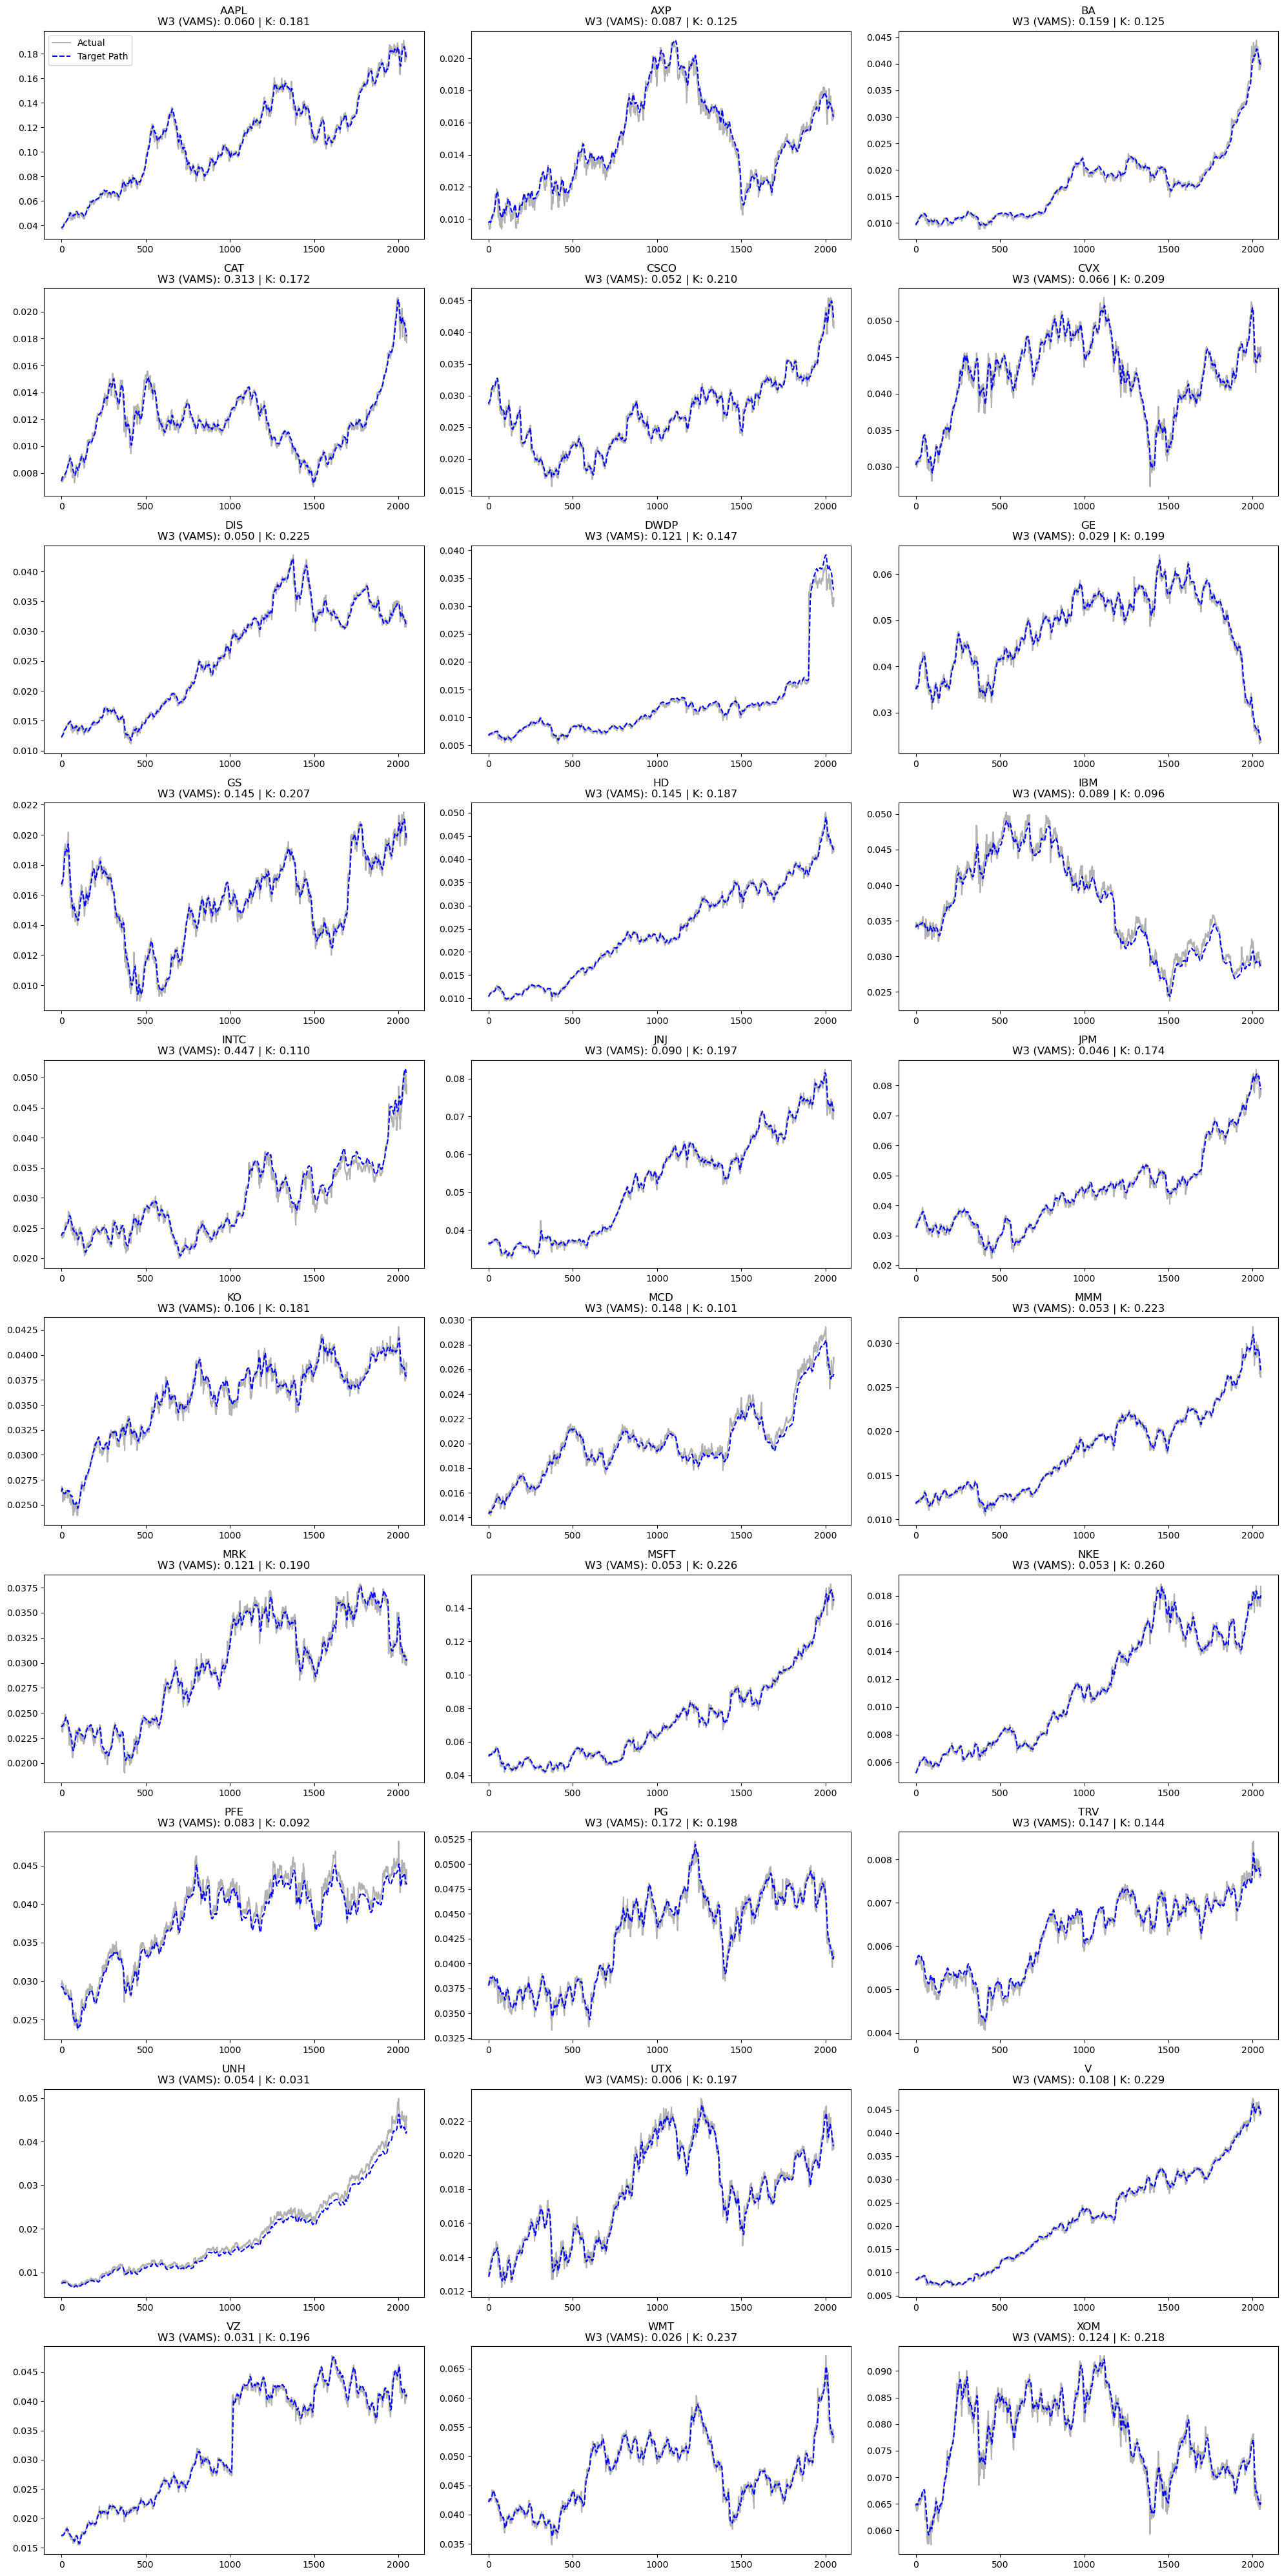

In [138]:
# --- CELL 16: Charts ---
n_cols = 3
n_rows = (num_stocks_2 + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Get calibrated weights
weights_plot = tf.nn.softmax(w_logits_2, axis=1).numpy()

for i in range(num_stocks_2):
    # Log-space signals
    z1_log = tf.math.log(1.0 + z1_t[:, i])
    z2_log = tf.math.log(1.0 + z2_t[:, i])
    z3_log = z3_t[:, i]  # Already in log space from VATSM
    
    # Initial log price
    log_x0 = tf.math.log(x_t[0, i])
    
    # Weighted drift
    W1, W2, W3 = weights_plot[i, 0], weights_plot[i, 1], weights_plot[i, 2]
    wtd_returns = W1 * z1_log + W2 * z2_log + W3 * z3_log
    
    # Reconstruct target path
    path_log = log_x0 + tf.math.cumsum(wtd_returns)
    path_arith = tf.exp(path_log).numpy()
    
    # Plotting
    axes[i].plot(x_t[:, i].numpy(), color='black', alpha=0.3, label='Actual')
    axes[i].plot(path_arith, color='blue', linestyle='--', linewidth=1.5, label='Target Path')
    
    # Metadata
    axes[i].set_title(f"{df_cap.columns[i]}\nW3 (VAMS): {W3:.3f} | K: {kappa_2[i].numpy():.3f}")
    if i == 0: 
        axes[i].legend()

# Remove empty subplots
for j in range(num_stocks_2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

With an NLL improvement of 511 (LR=1022), and consistently lower sigma values, the addition of the sliding VAM term does improve the calibration of the IRL-based model. This likelihood gain exceeds standard critical thresholds, indicating that adaptive lookback dynamics contain information not captured by fixed moving-average specifications. At the asset level, equities such as CAT and INTC exhibit elevated 𝑊3 loads, suggesting that adaptive momentum plays a larger role in shaping their effective drift, whereas names like WMT and VZ remain primarily explained by short-horizon price dynamics. 

By way of further analysis, it would be interesting to apply the this framework across firm size, sector, and geography to see if useful patterns emerge. 

## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

In [109]:
# ---CELL 17: Datafram Setup ---

# read the data to a Dataframe
SPX_S = pd.read_csv('spx_holdings_and_spx_closeprice.csv')

# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=SPX_S.shape[0], freq='B')
SPX_S['date'] = dates
SPX_S.set_index('date', inplace=True)

# Define the universe (ordered largest to smallest, 3 large, 3 mid, 3 small)
universe = ['SPX', 'AAPL', 'XOM', 'MSFT', 'DTE', 'AEE', 'WEC', 'NWL', 'ZION', 'DO']
df_SPX = SPX_S[universe].copy()

# Calculating MAs
spx_window_1 = 10
spx_window_2 = 30
spx_short_rolling = df_SPX.rolling(window=spx_window_1).mean()
spx_long_rolling = df_SPX.rolling(window=spx_window_2).mean()

spx_short_rolling.head(20)
spx_long_rolling.tail()

,SPX,AAPL,XOM,MSFT,DTE,AEE,WEC,NWL,ZION,DO
date,,,,,,,,,,
2023-06-06,"1,787.291000",76.898003,94.222000,37.633233,67.927333,36.183667,41.626000,30.122000,28.999800,59.725333
2023-06-07,"1,787.726667",77.032480,94.377000,37.652567,67.766667,36.139667,41.571333,30.163000,28.988800,59.579000
2023-06-08,"1,789.316000",77.153057,94.628667,37.650567,67.646333,36.130000,41.552667,30.237667,28.993133,59.465667
2023-06-09,"1,790.619667",77.265153,94.835667,37.586233,67.493333,36.102000,41.516333,30.329000,29.005300,59.308000
2023-06-12,"1,792.992000",77.439097,95.059667,37.562900,67.401667,36.098333,41.500333,30.427333,29.037967,59.156667


In [139]:
# ---CELL 18: Data Prep ---

# Global Scaling
avg_spx = df_SPX.sum(axis=1).mean()
df_spx_avg = df_SPX / avg_spx

spx_vam_S = np.log(df_spx_avg)
spx_vam_r = spx_vam_S.diff(1)

# Re-basing SMAs
spx_short_avg = spx_short_rolling / avg_spx
spx_long_avg = spx_long_rolling / avg_spx
spx_short_rebased = spx_short_avg / spx_short_avg.apply(lambda x: x.loc[x.first_valid_index()])
spx_long_rebased = spx_long_avg / spx_long_avg.apply(lambda x: x.loc[x.first_valid_index()])

# Dynamic lookback
spx_vol_short = spx_vam_r.rolling(window=10).std()
spx_vol_long = spx_vam_r.rolling(window=60).std()
spx_vol_ratio = (spx_vol_short / spx_vol_long).clip(0, 0.9).fillna(1.0)
spx_lb_window = (10 + (60 - 10) * (1.0 - spx_vol_ratio)).astype(int)

# Momentum: (Price[t] - Price[t-lb]) / Price[t-lb]
spx_vam_signal = pd.DataFrame(index=df_spx_avg.index, columns=df_spx_avg.columns)

for col in df_spx_avg.columns:
    prices = df_spx_avg[col].values
    lbs = spx_lb_window[col].values
    mom_array = np.zeros(len(prices))
    
    for i in range(60, len(prices)):
        lb = lbs[i]
        past_price = prices[i - lb]
        # Log-momentum scaled by lookback to get average daily drift
        mom_array[i] = np.log(prices[i] / past_price) / lb
            
    spx_vam_signal[col] = mom_array

# Signals (Arithmetic Returns)
spx_signal_1 = spx_short_rebased.pct_change(periods=1, fill_method=None).shift(-1)
spx_signal_2 = spx_long_rebased.pct_change(periods=1, fill_method=None).shift(-1)
spx_signal_3 = spx_vam_signal.shift(-1)

# Alignment
spx_subset = df_spx_avg[:-1]
spx_common_idx = spx_signal_1.dropna().index.intersection(spx_signal_2.dropna().index).intersection(spx_subset.index)

spx_x_data = spx_subset.loc[spx_common_idx]
spx_z1_data = spx_signal_1.loc[spx_common_idx]
spx_z2_data = spx_signal_2.loc[spx_common_idx]
spx_z3_data = spx_signal_3.loc[spx_common_idx]

# Tensors
spx_x_t = tf.constant(spx_x_data.values, dtype=tf.float32)
spx_z1_t = tf.constant(spx_z1_data.values, dtype=tf.float32)
spx_z2_t = tf.constant(spx_z2_data.values, dtype=tf.float32)
spx_z3_t = tf.constant(spx_z3_data.values, dtype=tf.float32)

num_steps, num_stocks = spx_x_t.shape
print(f"S&P Data Prepared. Steps: {num_steps}, Stocks: {num_stocks}")


S&P Data Prepared. Steps: 3345, Stocks: 10


In [ ]:
# --- CELL 19: Model Definition ---

# Variable Initializations
kappa_spx = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="kappa_spx")
sigma_spx = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="sigma_spx")
# Softmax Logits - 3 Signals:
w_logits_spx = tf.Variable(tf.random.normal([num_stocks, 3], mean=0.0, stddev=0.1), name="w_logits_spx")

def get_loss_spx():
    # Softmax Normalization (Regularization)
    weights = tf.nn.softmax(w_logits_spx, axis=1)
    W1 = weights[:, 0] # MA10
    W2 = weights[:, 1] # MA30
    W3 = weights[:, 2] # VAM Weight
    
    # Log Returns
    log_x = tf.math.log(spx_x_t)
    log_x_next = tf.math.log(tf.roll(spx_x_t, shift=-1, axis=0))
    actual_log_r = log_x_next - log_x
    
    z1_log = tf.math.log(1.0 + spx_z1_t)
    z2_log = tf.math.log(1.0 + spx_z2_t)
    z3_log = spx_z3_t # VAM as drift term

    # Log Mean Projection
    log_x0 = tf.slice(log_x, [0, 0], [1, -1])
    wtd_returns = W1 * z1_log + W2 * z2_log + W3 * z3_log
    theta_log = log_x0 + tf.math.cumsum(wtd_returns, axis=0)
    
    # Expected Return
    reversion = kappa_spx * (theta_log - log_x)
    exp_ret = wtd_returns + reversion
    
    # Residuals
    v_res = (actual_log_r - exp_ret)[:-1, :]
    
    # Gaussian NLL
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma_spx))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma_spx)))
    
    NLL = 0.5 * (sq_dist + log_det)

    return NLL

In [ ]:
# --- CELL 20: Optimization ---
optimizer_spx = tf.optimizers.Adam(learning_rate=0.001)
variables_spx = [kappa_spx, sigma_spx, w_logits_spx]

print("Calibrating S&P Universe Model...")
for i in range(2501):
    with tf.GradientTape() as tape:
        loss_val = get_loss_spx()
    
    # Gradients
    grads = tape.gradient(loss_val, variables_spx)
    optimizer_spx.apply_gradients(zip(grads, variables_spx))
    
    # Stability constraints
    kappa_spx.assign(tf.maximum(0.00001, kappa_spx))
    sigma_spx.assign(tf.maximum(0.00001, sigma_spx))
    
    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val.numpy():.4f}")

print("Done")

Calibrating S&P Universe Model...
Iteration    0 | Loss: -28573.9141
Iteration  500 | Loss: -97828.6094
Iteration 1000 | Loss: -118133.4688
Iteration 1500 | Loss: -118189.0781
Iteration 2000 | Loss: -118222.9062
Iteration 2500 | Loss: -118255.1250
I tried


In [171]:
# --- CELL 21: Results ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

final_weights_spx = tf.nn.softmax(w_logits_spx, axis=1).numpy()
W1_final_spx = final_weights_spx[:, 0]
W2_final_spx = final_weights_spx[:, 1]
W3_final_spx = final_weights_spx[:, 2]

results_spx = {
    'Ticker': df_SPX.columns,
    'Kappa (Log)': kappa_spx.numpy(),
    'Sigma (Log)': sigma_spx.numpy(),
    'W1 (MA10)': W1_final_spx,
    'W2 (MA30)': W2_final_spx,
    'W3 (VAMS)': W3_final_spx,
    'Sum_Weights': W1_final_spx + W2_final_spx + W3_final_spx
}
df_results_spx = pd.DataFrame(results_spx)

print("----------- S&P Universe: Final Calibration Results (VAMS Integrated) -----------")
df_results_spx

----------- S&P Universe: Final Calibration Results (VAMS Integrated) -----------


,Ticker,Kappa (Log),Sigma (Log),W1 (MA10),W2 (MA30),W3 (VAMS),Sum_Weights
0,SPX,0.021101,0.012585,0.795519,0.022069,0.182412,1.000000
1,AAPL,0.059806,0.027977,0.796692,0.184762,0.018546,1.000000
2,XOM,0.108611,0.015020,0.821060,0.040723,0.138217,1.000000
3,MSFT,0.083789,0.019287,0.948563,0.032977,0.018459,1.000000
4,DTE,0.152631,0.012821,0.635153,0.121241,0.243606,1.000000
5,AEE,0.040927,0.013315,0.728112,0.126358,0.145530,1.000000
6,WEC,0.065356,0.011606,0.690826,0.089086,0.220088,1.000000
7,NWL,0.016520,0.020866,0.730850,0.147079,0.122071,1.000000
8,ZION,0.053508,0.030080,0.628687,0.206360,0.164953,1.000000
9,DO,0.099591,0.023290,0.732271,0.248901,0.018828,1.000000


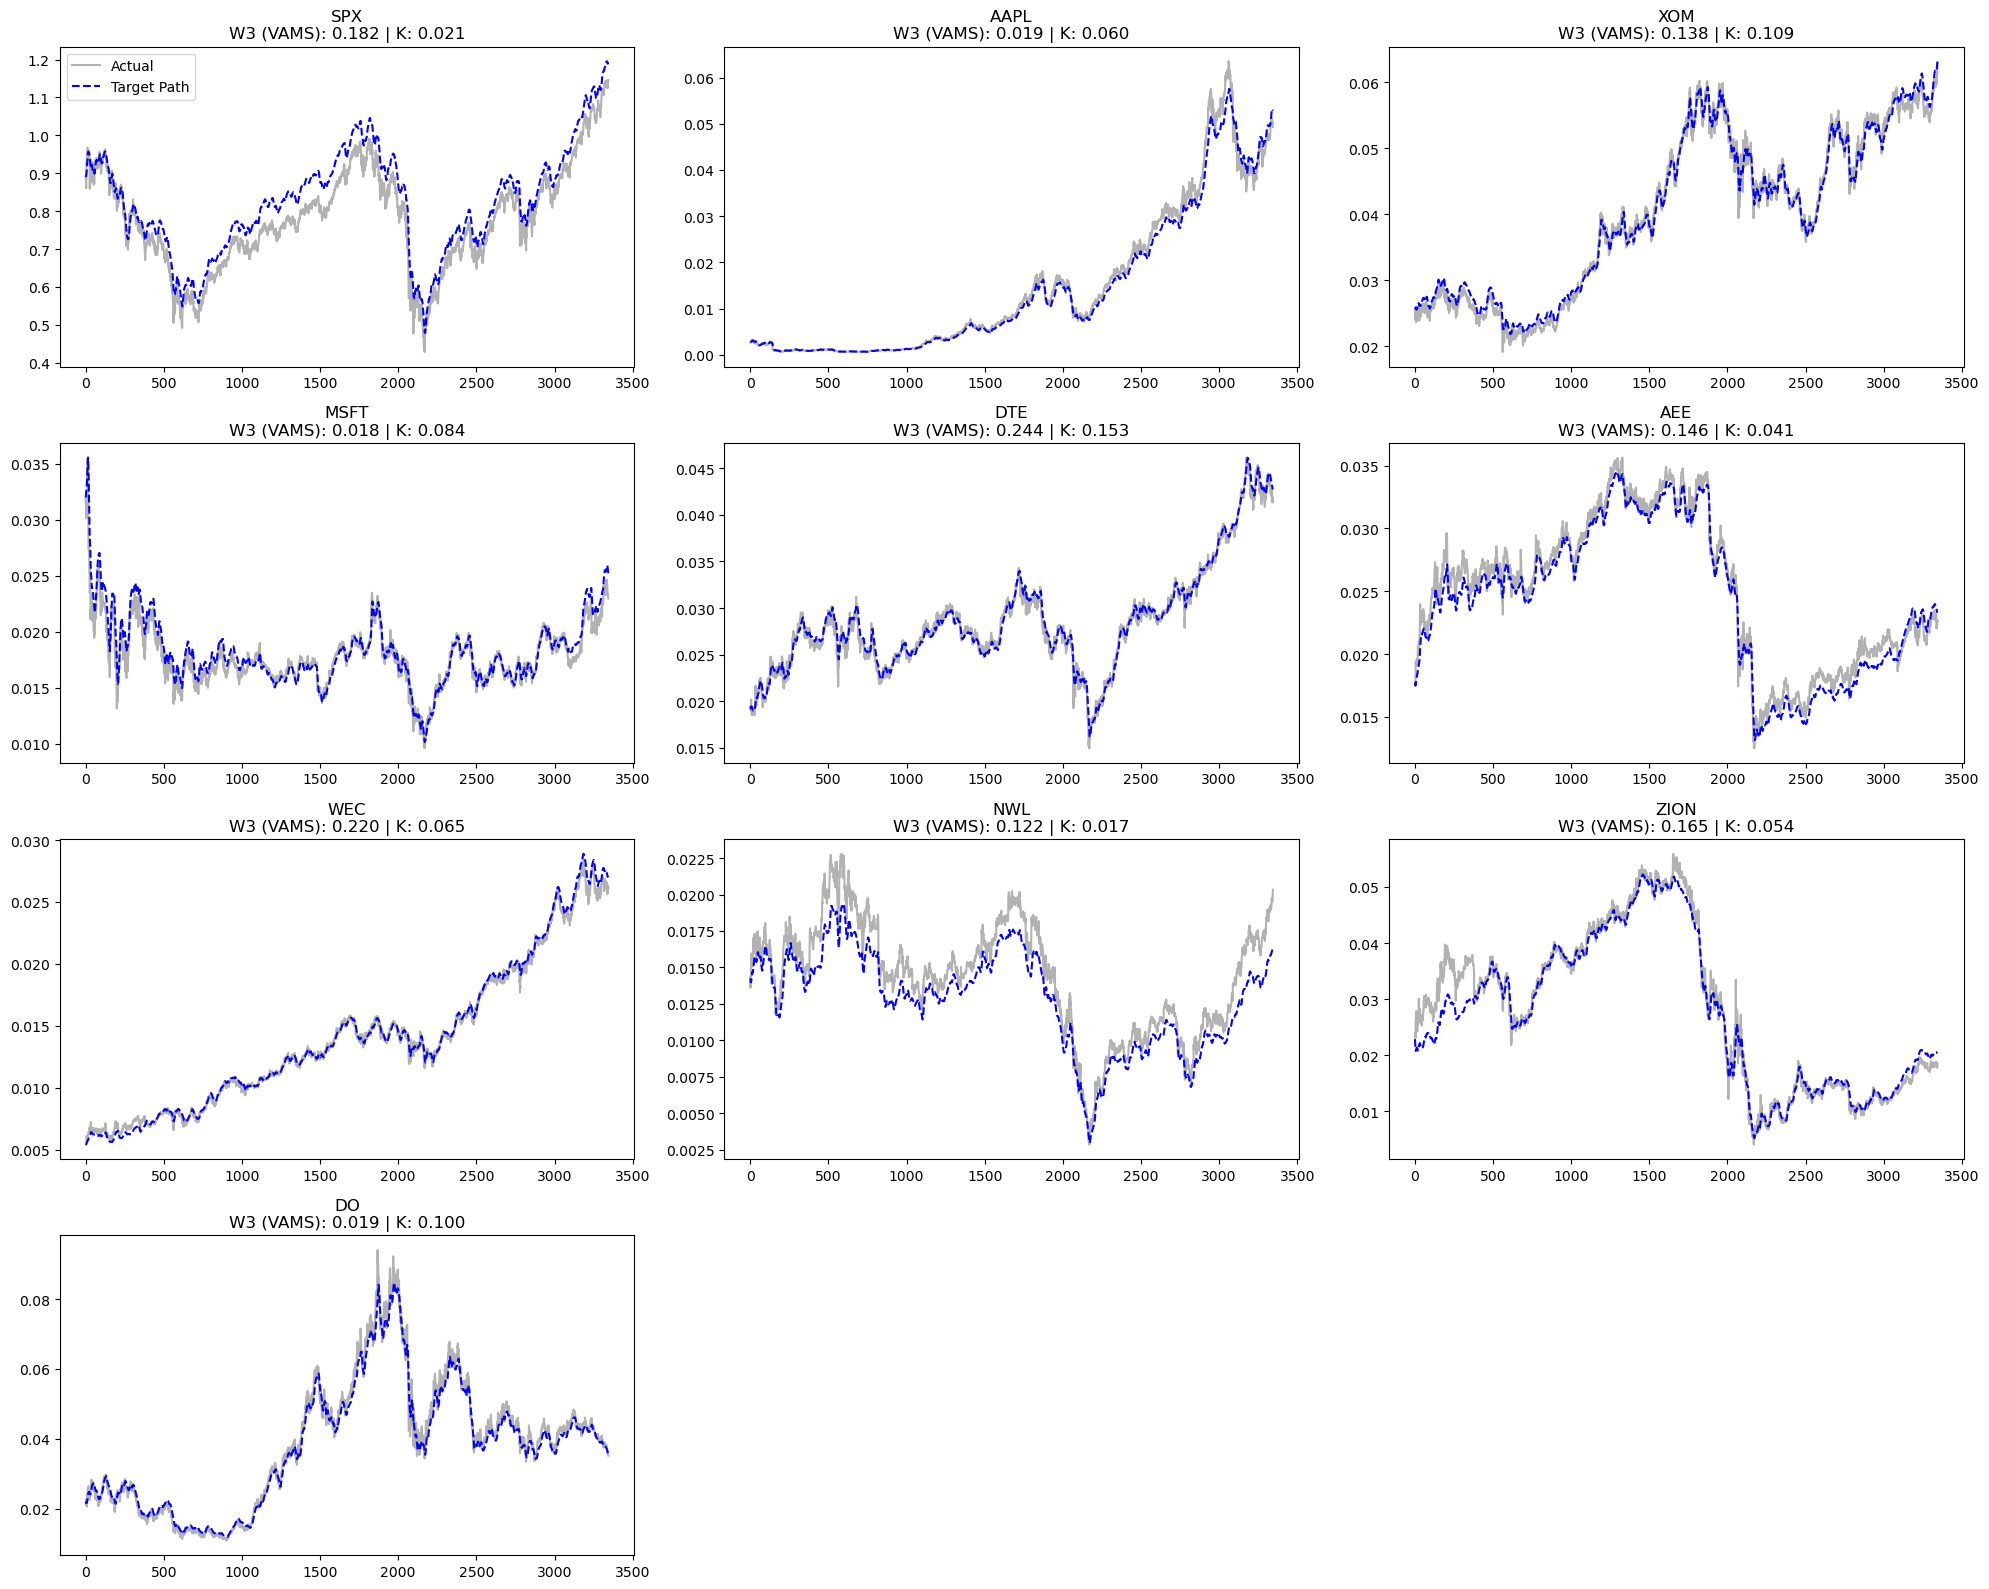

In [ ]:
# --- CELL 22: Charts ---
n_cols = 3
n_rows = (num_stocks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Get calibrated weights
weights_plot = tf.nn.softmax(w_logits_spx, axis=1).numpy()

for i in range(num_stocks):
    # Signals
    log_x0 = tf.math.log(spx_x_t[0, i])
    z1_log = tf.math.log(1.0 + spx_z1_t[:, i])
    z2_log = tf.math.log(1.0 + spx_z2_t[:, i])
    z3_log = spx_z3_t[:, i]  # VATSM already in log space

    # Weighted Drift
    W1, W2, W3 = weights_plot[i, 0], weights_plot[i, 1], weights_plot[i, 2]
    wtd_returns = W1 * z1_log + W2 * z2_log + W3 * z3_log
    
    # Path Reconstruction
    path_log = log_x0 + tf.math.cumsum(wtd_returns)
    path_arith = tf.exp(path_log).numpy()
    
    # Plotting
    axes[i].plot(spx_x_t[:, i].numpy(), color='black', alpha=0.3, label='Actual')
    axes[i].plot(path_arith, color='blue', linestyle='--', linewidth=1.5, label='Target Path')
    
    # Metadata
    axes[i].set_title(f"{df_SPX.columns[i]}\nW3 (VAMS): {W3:.3f} | K: {kappa_spx[i].numpy():.3f}")
    if i == 0: 
        axes[i].legend()

# Remove empty subplots - FIXED
for j in range(num_stocks, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


Let's test whether the addition of the VAM was an improvement and further whether the IRL model itself can be predictive.

This analysis does not introduce a new learning model, but instead evaluates whether the IRL-implied structure extracted from market behavior contains predictive information beyond a random walk benchmark.

In [155]:
target_df = df_SPX.copy()
print(f"Validating Model on S&P Universe: {target_df.columns.tolist()}")

Validating Model on S&P Universe: ['SPX', 'AAPL', 'XOM', 'MSFT', 'DTE', 'AEE', 'WEC', 'NWL', 'ZION', 'DO']


In [156]:
# --- CELL 23: Ablated 2-Signal Model ---

# Variable Initializations
kappa_spx_2s = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="kappa_spx")
sigma_spx_2s = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="sigma_spx")
# Softmax Logits - 3 Signals:
w_logits_spx_2s = tf.Variable(tf.random.normal([num_stocks, 2], mean=0.0, stddev=0.1), name="w_logits_spx")

def get_loss_spx_2s():
    # Softmax Normalization (Regularization)
    weights_2s = tf.nn.softmax(w_logits_spx_2s, axis=1)
    W1 = weights_2s[:, 0] # MA10
    W2 = weights_2s[:, 1] # MA30

    # Log Returns
    log_x = tf.math.log(spx_x_t)
    log_x_next = tf.math.log(tf.roll(spx_x_t, shift=-1, axis=0))
    actual_log_r = log_x_next - log_x
    
    z1_log = tf.math.log(1.0 + spx_z1_t)
    z2_log = tf.math.log(1.0 + spx_z2_t)

    # Log Mean Projection
    log_x0 = tf.slice(log_x, [0, 0], [1, -1])
    wtd_returns = W1 * z1_log + W2 * z2_log
    theta_log = log_x0 + tf.math.cumsum(wtd_returns, axis=0)
    
    # Expected Return
    reversion = kappa_spx_2s * (theta_log - log_x)
    exp_ret = wtd_returns + reversion
    
    # Residuals
    v_res = (actual_log_r - exp_ret)[:-1, :]
    
    # Gaussian NLL
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma_spx_2s))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma_spx_2s)))
    
    NLL = 0.5 * (sq_dist + log_det)

    return NLL

In [158]:
# --- CELL 24: Split Train/Test ---
split = int(len(spx_x_data) * 0.7)
test_idx = spx_x_data.index[split:]

# Actual Next Price
actual_next = spx_x_data.shift(-1).loc[test_idx].dropna()

# Align inputs to test set
x_test = spx_x_data.loc[actual_next.index]
z1_test = spx_z1_data.loc[actual_next.index]
z2_test = spx_z2_data.loc[actual_next.index]
z3_test = spx_z3_data.loc[actual_next.index]

In [ ]:
# --- CELL 25: Run Diagnostics ---
results_list = []

for ticker in target_df.columns:
    
    # Weights from Part 3
    try:
        row_3sig = df_results_spx[df_results_spx['Ticker'] == ticker].iloc[0]
        kappa_3 = row_3sig['Kappa (Log)']
        w1_3 = row_3sig['W1 (MA10)']
        w2_3 = row_3sig['W2 (MA30)']
        w3_3 = row_3sig['W3 (VAMS)']
    except:
        kappa_3, w1_3, w2_3, w3_3 = 0.05, 0.33, 0.33, 0.33
    
    # 2-signal weights from ablation
    try:
        row_2sig = df_results_spx_2s[df_results_spx_2s['Ticker'] == ticker].iloc[0]
        w1_2 = row_2sig['W1 (MA10)']
        w2_2 = row_2sig['W2 (MA30)']
    except:
        w1_2, w2_2 = 0.5, 0.5
    
    # Construct Signals
    z1_log = np.log(1 + z1_test[ticker])
    z2_log = np.log(1 + z2_test[ticker])
    z3_log = z3_test[ticker]

    # Weighted drifts
    drift_3sig = w1_3 * z1_log + w2_3 * z2_log + w3_3 * z3_log
    drift_2sig = w1_2 * z1_log + w2_2 * z2_log
    
    # Predictions (IRL: price * exp(drift))
    pred_base = x_test[ticker]
    pred_3sig = x_test[ticker] * np.exp(drift_3sig)
    pred_2sig = x_test[ticker] * np.exp(drift_2sig)
    
    # Errors
    err_base = np.sqrt(np.mean((actual_next[ticker] - pred_base)**2))
    err_3sig = np.sqrt(np.mean((actual_next[ticker] - pred_3sig)**2))
    err_2sig = np.sqrt(np.mean((actual_next[ticker] - pred_2sig)**2))
    
    results_list.append({
        'Ticker': ticker,
        'Base RMSE': err_base,
        '2-Sig RMSE': err_2sig,
        '3-Sig RMSE': err_3sig,
        '3-Sig vs Base': f"{100 * (err_base - err_3sig) / err_base:.2f}%",
        '3-Sig vs 2-Sig': f"{100 * (err_2sig - err_3sig) / err_2sig:.2f}%"
    })

    res_df = pd.DataFrame(results_list)

# Output results
print("--- PART 4: S&P 500 VALIDATION RESULTS ---")
print(res_df.to_string(index=False))

# Summary
print("\n" + "="*50)
avg_imp_pct = res_df['3-Sig vs Base'].str.rstrip('%').astype(float).mean()
avg_vam_pct = res_df['3-Sig vs 2-Sig'].str.rstrip('%').astype(float).mean()

print(f"3-Signal vs Baseline: Average improvement of {avg_imp_pct:.2f}%")
print(f"VAM Contribution: Average improvement of {avg_vam_pct:.2f}%")

if avg_imp_pct > 0:
    print(f"\nCONCLUSION: The IRL model beat the Random Walk baseline by {avg_imp_pct:.2f}% on average.")
else:
    print("\nCONCLUSION: The model did not outperform the Random Walk (Efficient Market).")

--- PART 4: S&P 500 VALIDATION RESULTS ---
Ticker  Base RMSE  2-Sig RMSE  3-Sig RMSE 3-Sig vs Base 3-Sig vs 2-Sig
   SPX   0.008525    0.008200    0.008137         4.54%          0.76%
  AAPL   0.000703    0.000676    0.000673         4.26%          0.36%
   XOM   0.000574    0.000549    0.000545         5.07%          0.85%
  MSFT   0.000265    0.000255    0.000254         4.37%          0.58%
   DTE   0.000341    0.000329    0.000327         4.07%          0.62%
   AEE   0.000222    0.000214    0.000213         4.05%          0.76%
   WEC   0.000205    0.000197    0.000195         4.77%          0.82%
   NWL   0.000195    0.000186    0.000185         5.19%          0.78%
  ZION   0.000321    0.000309    0.000307         4.40%          0.52%
    DO   0.000796    0.000764    0.000760         4.54%          0.53%

3-Signal vs Baseline: Average improvement of 4.53%
VAM Contribution: Average improvement of 0.66%

CONCLUSION: The IRL model beat the Random Walk baseline by 4.53% on average.

The out-of-sample validation demonstrates that the IRL model captures predictive structure beyond a random walk. The 3-signal VATSM model achieves a 4.53% average RMSE improvement over the baseline across the test sample, with the adaptive momentum signal contributing an additional 0.66% improvement over the 2-signal model alone.

These results suggest that regime-adaptive signals—particularly those that adjust their lookback windows based on volatility ratios—can extract information orthogonal to fixed-window moving averages.

While the improvements are modest, they establish a foundation for further feature engineering. Future work could explore additional regime-aware signals or use the IRL framework itself as a feature selection mechanism.

However, these modest improvements should not be interpreted as evidence of market inefficiency or predictable profit opportunities. Transaction costs, slippage, and the practical challenges of implementing such signals in live trading would likely eliminate any theoretical edge. Rather, this exercise establishes the IRL framework as a tool for understanding which technical features contain statistically meaningful information about price dynamics.